In [50]:
from argopy import DataFetcher as ArgoDataFetcher

In [51]:
ilat = -10
flat = 10
ilon = -130
flon = -110
idepth = 100
fdepth = 300
idate = "2005-01-01"
fdate = "2006-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 8772)
Coordinates:
  * N_POINTS         (N_POINTS) int64 0 1 2 3 4 5 ... 8767 8768 8769 8770 8771
    LONGITUDE        (N_POINTS) float64 -127.4 -127.4 -127.4 ... -127.0 -127.0
    LATITUDE         (N_POINTS) float64 9.465 9.465 9.465 ... -0.378 -0.378
    TIME             (N_POINTS) datetime64[ns] 2005-01-01T09:34:05 ... 2005-1...
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 81 81 81 81 81 81 81 ... 11 11 11 11 11 11
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 5900232 5900232 ... 5901015 5901015
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 105.4 115.3 125.5 ... 269.8 283.9 297.5
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 34.71 34.71 34.73 ... 34.89 34.89 34.88
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float64 12.28 12.06 11.83 ... 12.58 12.44 12.36
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/13
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [52]:
argo_profiles = ds.argo.point2profile()
argo_interp = argo_profiles.argo.interp_std_levels([250])
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]]
selected_vars

<xarray.Dataset>
Dimensions:            (N_PROF: 414, PRES_INTERPOLATED: 1)
Coordinates:
    LATITUDE           (N_PROF) float64 9.465 8.144 1.128 ... -3.829 -0.378
    LONGITUDE          (N_PROF) float64 -127.4 -111.7 -124.1 ... -120.0 -127.0
    TIME               (N_PROF) datetime64[ns] 2005-01-01T09:34:05 ... 2005-1...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
  * N_PROF             (N_PROF) int64 292 238 294 114 0 ... 237 229 328 34 413
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 10.43 10.63 ... 12.67
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/13
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

<xarray.Dataset>
Dimensions:            (N_PROF: 414, PRES_INTERPOLATED: 1)
Coordinates:
    LONGITUDE          (N_PROF) float64 -127.4 -111.7 -124.1 ... -120.0 -127.0
    TIME               (N_PROF) datetime64[ns] 2005-01-01T09:34:05 ... 2005-1...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 250
    LATITUDE           (N_PROF) float64 9.465 8.144 1.128 ... -3.829 -0.378
  * N_PROF             (N_PROF) int64 292 238 294 114 0 ... 237 229 328 34 413
Data variables:
    CYCLE_NUMBER       (N_PROF) float64 81.0 67.0 10.0 26.0 ... 44.0 102.0 11.0
    DATA_MODE          (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION          (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) float64 5.9e+06 4.9e+06 ... 3.9e+06 5.901e+06
    PRES               (N_PROF, PRES_INTERPOLATED) float64 250.0 250.0 ... 250.0
    PSAL               (N_PROF, PRES_INTERPOLATED) float64 34.71 34.73 ... 34.9
    TEMP               (N_PROF, PRES_INTERPOLATED) float64 10.43 10.63 ... 12.67
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/13
    Fetched_constraints:  phy_[x=-130.00/-110.00; y=-10.00/10.00; z=100.0/300...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from typing import Iterable


def get_harmonics(nharmonics, time, period=365):
    """Compute the requested number of harmonics
    for a set time.
    
    Parameters
    ----------
    nharmonics : int
        Number of harmonics to compute
    time : int, Iterable
        Time point within period of oscillation.
        This can be either a single int or a 1d-array
    period : int, optional
        Period of oscillation
        
    Returns
    -------
    harmonics: 2d-array
        Array of shape (len(time), nharmonics*2) where
        nharmonics*2 accounts for the cos and sin terms.
    """
    harmonics = np.arange(1, nharmonics + 1)
    if isinstance(time, Iterable):
        time = np.asarray(time)[:, np.newaxis]
        harmonics = harmonics[np.newaxis, :]
    phase = 2 * np.pi * harmonics * time / period
    return np.concatenate([np.cos(phase), np.sin(phase)], axis=-1)


def build_basis(lat, lon, time, nharmonics):
    """Build the 2d local polynomial regression basis
    according to Park2020
    """
    local_polynomlial_reg = np.ones((lat.size, 6 + nharmonics * 2))
    local_polynomlial_reg[:, 1] = lon
    local_polynomlial_reg[:, 2] = lat
    local_polynomlial_reg[:, 3] = lon * lat
    local_polynomlial_reg[:, 4] = lon ** 2
    local_polynomlial_reg[:, 5] = lat ** 2
    local_polynomlial_reg[:, 6:] = get_harmonics(nharmonics, time)
    return local_polynomlial_reg


def find_mean_state(lat, lon, time, data, nharmonics=2):
    """Find the mean state
    
    Parameters
    ----------
    lat, lon, time, data : 1d-array
        Arrays containing latitude, longitude, day of year and
        data.
    nharmonics: int, optional
        Number of harmonics to add into the basis functions
    """
    return lsq_linear(build_basis(lat, lon, time, nharmonics), data)

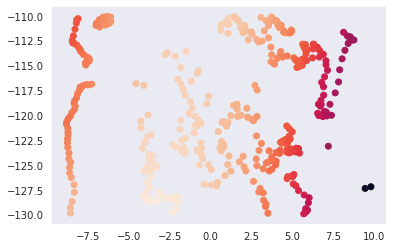

In [57]:
mean_state_fit = find_mean_state(
    selected_vars.LATITUDE,
    selected_vars.LONGITUDE,
    selected_vars.TIME.dt.dayofyear,
    selected_vars.TEMP.data.flatten(),
)
check_data = np.matmul(build_basis(selected_vars.LATITUDE, selected_vars.LONGITUDE, 40, 2), mean_state_fit.x)
plt.scatter(selected_vars.LATITUDE, selected_vars.LONGITUDE,c=check_data)

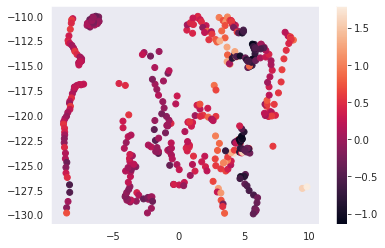

In [59]:
Anomaly = selected_vars.TEMP.squeeze() - check_data
cs = plt.scatter(selected_vars.LATITUDE, selected_vars.LONGITUDE,c=Anomaly)
plt.colorbar(cs)

In [86]:
import xarray as xr
import pandas as pd
Input_coordinates=xr.concat((selected_vars.LATITUDE,selected_vars.LONGITUDE,selected_vars.TIME.dt.dayofyear),pd.Index(['lon','lat','time'], name="coordinate")).T

In [87]:
import george as grg

In [88]:
Lxscale = 110e3*np.sin(2*np.pi/360*50)
Lyscale = 110e3

kernel_argo = np.var(Anomaly).values*grg.kernels.ExpSquaredKernel([100e3**2/Lxscale**2, 
                                                100e3**2/Lyscale**2, 
                                                30**2
                                               ], ndim=3)

In [89]:
gp_argo = grg.GP(kernel_argo)

In [111]:
gp_argo.compute(Input_coordinates, 0.01)

In [117]:
test_pts_argo = np.array(np.meshgrid(np.linspace(-10,10,30), 
                       np.linspace(-130,-116,30),
                        np.linspace(0,365,30))).reshape(3,-1).T
test_pts_argo = xr.DataArray(test_pts_argo,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts_argo.shape[0]), ['lon','lat','time']] ) 

In [118]:
pred_argo, pred_var_argo = gp_argo.predict(Anomaly, test_pts_argo, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_argo = xr.DataArray(pred_argo,  dims={"test_pt_num"})
pred_var_argo = xr.DataArray(pred_var_argo,  dims={"test_pt_num"})

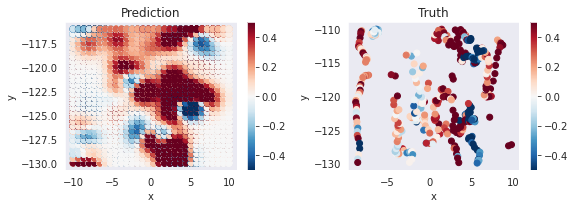

In [119]:
plt.figure(figsize=(8,3))
plt.subplot(121)

plt.scatter(test_pts_argo.sel(coordinate='lon'), 
            test_pts_argo.sel(coordinate='lat'), 
            c=pred_argo, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')

plt.subplot(122)
x_sel = Input_coordinates

y_sel = Anomaly

plt.scatter(x_sel.sel(coordinate='lon'), x_sel.sel(coordinate='lat'), 
            c=y_sel, vmin=-.5, vmax=.5, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

In [121]:
print("Initial ln-likelihood: {0:.2f}".format(gp_argo.log_likelihood(Anomaly)))

Initial ln-likelihood: -3651.26


In [126]:
from scipy.optimize import minimize


def neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.log_likelihood(Anomaly)

def grad_neg_ln_like_argo(p):
    gp_argo.set_parameter_vector(p)
    return -gp_argo.grad_log_likelihood(Anomaly)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [127]:
%time result_argo = minimize(neg_ln_like_argo,gp_argo.get_parameter_vector(), jac=grad_neg_ln_like_argo)

CPU times: user 7.33 s, sys: 7.53 s, total: 14.9 s
Wall time: 3.71 s


In [131]:
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

NameError: name 'gp' is not defined